# Relax Data Science Challenge

### Task: Identify which factors predict future user adoption.

Definition: **adopted user** is a user who has logged into the product on three separate days in at least one seven-day period.

1. A user table ("takehome_users") with data on 12,000 users who signed up for the product in the last two years. This table includes:

- name: the user's name
- object_id: the user's id
- email: email address
- creation_source: how their account was created. This takes on one of 5 values:
    - PERSONAL_PROJECTS: invited to join another user's personal workspace
    - GUEST_INVITE: invited to an organization as a guest (limited permissions)
    - ORG_INVITE: invited to an organization (as a full member)
    - SIGNUP: signed up via the website
    - SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)
- creation_time: when they created their account
- last_session_creation_time: unix timestamp of last login
- opted_in_to_mailing_list: whether they have opted into receiving marketing emails
- enabled_for_marketing_drip: whether they are on the regular marketing email drip
- org_id: the organization (group of users) they belong to
- invited_by_user_id: which user invited them to join (if applicable).

2. A usage summary table ("takehome_user_engagement") that has a row for each day that a user logged into the product.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

In [2]:
# Read csv files into Pandas DataFrames

users = pd.read_csv('takehome_users.csv', encoding='latin-1')
engagement = pd.read_csv('takehome_user_engagement.csv', index_col='time_stamp')

In [3]:
# View users table

users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
# View user engagement table

engagement.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [5]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
Index: 207917 entries, 2014-04-22 03:53:30 to 2014-01-26 08:57:12
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  207917 non-null  int64
 1   visited  207917 non-null  int64
dtypes: int64(2)
memory usage: 4.8+ MB


In [6]:
# Convert time_stamp index to datetime data type

engagement.index = pd.to_datetime(engagement.index)

In [7]:
# Confirm time_stamp index is converted to datetime

engagement.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207917 entries, 2014-04-22 03:53:30 to 2014-01-26 08:57:12
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  207917 non-null  int64
 1   visited  207917 non-null  int64
dtypes: int64(2)
memory usage: 4.8 MB


The user engagement table will be used to determine which users are adopted users for further analysis.

In [8]:
# Group by visits every 7 days and user_id

df = engagement.groupby([pd.Grouper(freq='7D'),'user_id']).sum()

In [9]:
df

visited
time_stamp user_id         
2012-05-31 50             1
           563            1
           1400           1
           1551           1
           1693           2
...                     ...
2014-05-29 11967          2
           11969          2
           11988          1
           11991          1
2014-06-05 4051           1

[68445 rows x 1 columns]

In [10]:
# Subset DataFrame by visits >= 3 and wrangle data into usable form
df = df[df['visited'] >= 3].unstack(level=1).melt()

In [11]:
df

,None,user_id,value
0,visited,728,3.0
1,visited,728,NaN
2,visited,728,NaN
3,visited,728,NaN
4,visited,728,NaN
...,...,...,...
148830,visited,11682,NaN
148831,visited,11682,NaN
148832,visited,11682,NaN
148833,visited,11682,NaN


In [12]:
# Create list of adopted user indices

adopt_list = list(df['user_id'].unique())

In [13]:
len(adopt_list)

1445

In [14]:
# Create feature for adopted users. 1 for adopted user, 0 for non-adopted user

users['adopted'] = 0

users['adopted'] = users['object_id'].apply(lambda x: 1 if users['object_id'].iloc[x-1] in adopt_list else 0)

In [15]:
users['adopted'].value_counts()

0    10555
1     1445
Name: adopted, dtype: int64

In [16]:
users['adopted'].head(10)

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    1
Name: adopted, dtype: int64

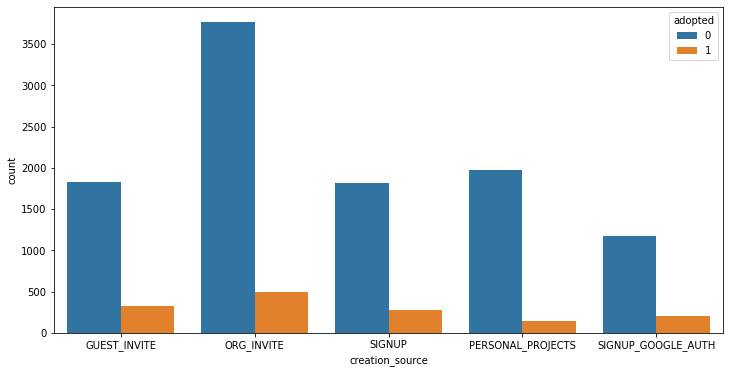

In [17]:
# Plot creation_source counts for adopted and non-adopted users

plt.subplots(figsize=(12,6))
_ = sns.countplot(data=users, x='creation_source', hue='adopted')
plt.show()

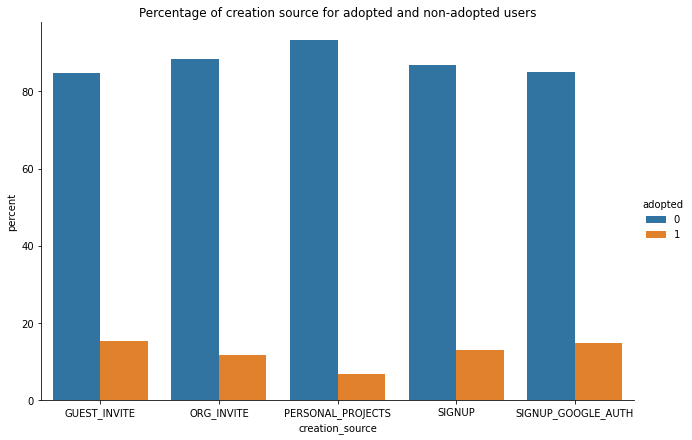

In [18]:
# Plot creation_source counts for adopted and non-adopted users by percentages

(users
.groupby('creation_source')['adopted']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x='creation_source', y='percent', hue='adopted', kind='bar', height=6, aspect=1.5))
plt.title('Percentage of creation source for adopted and non-adopted users')
plt.show()

PERSONAL_PROJECTS creation source has the least percentage of adopted users. GUEST_INVITE, SIGNUP_GOOGLE_AUTH, and SIGNUP have the highest percentages of adopted users.

In [19]:
users.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000,12000.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145,0.120417
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968,0.325462
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000,0.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000,0.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000,0.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000,0.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000,1.000000


In [20]:
(users['invited_by_user_id'].isna().sum() / len(users['invited_by_user_id']) - 1) * -1

0.5347500000000001

25% of users are opted in to mailing list.

15% of users are enabled for marketing drip.

12% of users are adopted users.

53% of users are invited by other users.

## Feature Engineering

In [21]:
# Create feature for days since account created

users['creation_time'] = pd.to_datetime(users['creation_time'])
users['account_days'] = max(users['creation_time']) - users['creation_time']
users['account_days'] = users['account_days'].dt.days
users['account_days']

0         38
1        196
2        437
3        374
4        498
        ... 
11995    266
11996    505
11997     33
11998    729
11999    124
Name: account_days, Length: 12000, dtype: int64

In [22]:
# View counts of ord_id

users['org_id'].value_counts().head(30)


0     319
1     233
2     201
3     168
4     159
6     138
5     128
9     124
7     119
10    104
8      97
14     87
12     75
11     75
17     74
18     73
16     72
13     72
20     68
15     64
24     63
25     62
28     61
23     60
30     59
22     58
33     57
40     57
21     56
27     55
Name: org_id, dtype: int64

In [23]:
# Create feature for total number of users 'org_total' in each organization 'org_id'

org_dict = users['org_id'].value_counts().to_dict()

users['org_total'] = 0

def get_org_total(x):
    return org_dict[x]

users['org_total'] = users['org_id'].apply(get_org_total)

In [24]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,account_days,org_total
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,38,75
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,0,196,233
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0,437,32
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0,374,233
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0,498,16


In [25]:
# Create binary feature 'invited' for 'invited_by_user_id'

users['invited'] = 1
users.loc[users['invited_by_user_id'].isna(), 'invited'] = 0

In [26]:
users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,account_days,org_total,invited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,38,75,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,0,196,233,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0,437,32,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0,374,233,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0,498,16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0,0,266,40,1
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN,0,505,25,0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0,0,33,27,1
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN,0,729,138,0


In [27]:
users.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,account_days,org_total,invited
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145,0.120417,317.942917,55.108500,0.534750
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968,0.325462,216.641423,64.023959,0.498812
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,2.000000,0.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000,0.000000,122.000000,21.000000,0.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000,0.000000,298.000000,29.000000,1.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000,0.000000,500.000000,55.000000,1.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000,1.000000,729.000000,319.000000,1.000000


## Modeling

In [28]:
# Drop unnecessary columns

X = users.drop(['object_id', 'creation_time', 'name', 'email', 'last_session_creation_time', 'org_id', 'invited_by_user_id', 'adopted'], axis=1)

In [29]:
# One-hot encode categorical feature creation_source

X = pd.get_dummies(X, columns=['creation_source'])


In [30]:
X

,opted_in_to_mailing_list,enabled_for_marketing_drip,account_days,org_total,invited,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,38,75,1,1,0,0,0,0
1,0,0,196,233,1,0,1,0,0,0
2,0,0,437,32,1,0,1,0,0,0
3,0,0,374,233,1,1,0,0,0,0
4,0,0,498,16,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
11995,0,0,266,40,1,0,1,0,0,0
11996,0,0,505,25,0,0,0,0,0,1
11997,1,1,33,27,1,1,0,0,0,0
11998,0,0,729,138,0,0,0,1,0,0


In [31]:
y = users['adopted']

In [32]:
print(X.shape)
print(y.shape)

(12000, 10)
(12000,)


In [33]:
# import scikit-learn libraries

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

In [34]:
# Split the data into to training and test variables

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [35]:
# Create Logistic Regression object

clf = LogisticRegression(class_weight='balanced', random_state=42)

In [36]:
# Fit X_train and y_train to model

clf.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [37]:
# Make predictions

y_pred = clf.predict(X_test)

In [38]:
# Create classification report

print(classification_report(y_test, y_pred))

# Create confusion matrix

cm = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.92      0.59      0.72      2111
           1       0.17      0.62      0.27       289

    accuracy                           0.59      2400
   macro avg       0.54      0.60      0.49      2400
weighted avg       0.83      0.59      0.66      2400



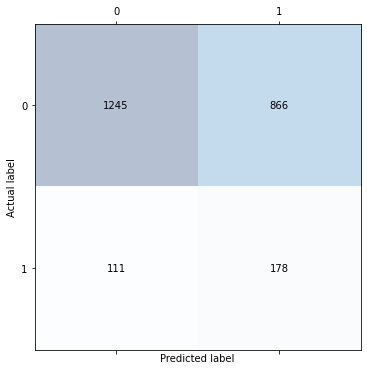

In [39]:
# Plot confusion matrix

fig, ax = plt.subplots(figsize = (6, 6))
ax.matshow(cm, cmap = 'Blues', alpha = 0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('Actual label');

The accuracy of the model is not very good at 59%.

The precision for the negative class is high at 92%, but precision for the positive class is low at 17%. The model predicts many false positives. Recall for both classes is similar to the accuracy score at 59%-62%.

In [40]:
# Get feature importances from model coefficients

importance = clf.coef_[0]

In [41]:
importance

array([ 0.06729341, -0.03883563,  0.00154457, -0.00507464,  0.05558269,
        0.17719252, -0.12160983, -0.67369264,  0.12255683,  0.22136159])

Feature: 0, Score: 0.06729
Feature: 1, Score: -0.03884
Feature: 2, Score: 0.00154
Feature: 3, Score: -0.00507
Feature: 4, Score: 0.05558
Feature: 5, Score: 0.17719
Feature: 6, Score: -0.12161
Feature: 7, Score: -0.67369
Feature: 8, Score: 0.12256
Feature: 9, Score: 0.22136


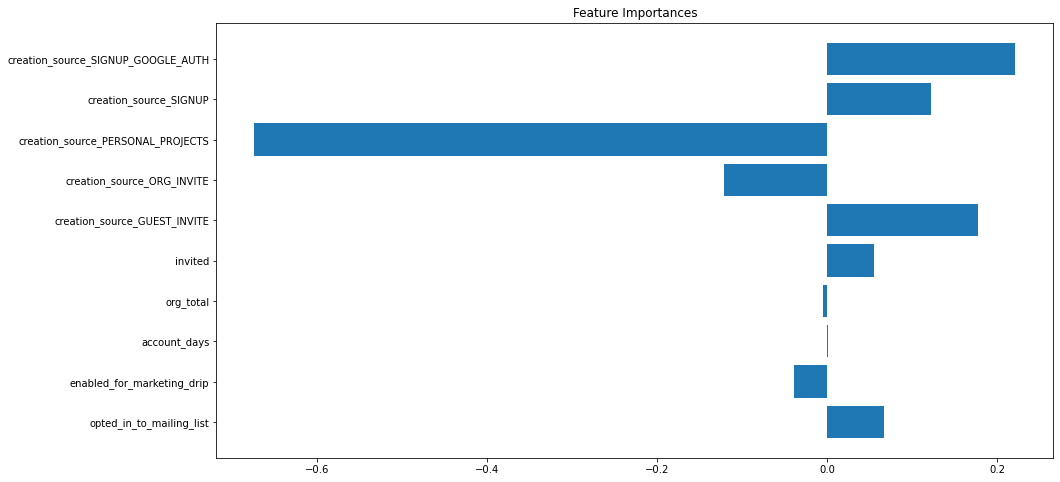

In [42]:
# Plot feature importances

for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.subplots(figsize=(15,8))
plt.barh(X_train.columns, importance)
plt.title('Feature Importances')
#plt.xticks(rotation=90)
plt.show()

## Conclusions

The logistic regression model predicts many false positives, so it may be of limited use for identifying adopted users. However, the model does a good job at predicting which users will not adopt. It may be useful for determining feature importances.

The most importance features positively influencing user adoption are SIGNUP_GOOGLE_AUTH, GUEST_INVITE, SIGNUP. This coincides with the bar plot of creation source percentages of adopted users.

Negatively influencing user adoption are PERSONAL_PROJECTS and ORG_INVITE. Of lesser importance are opted_in_to_mailing_list, enabled_for_marketing_drip, and invited. Of least importance are the size of the organization and time since account creation.